# Dimensionality reduction on trial features

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture
import pickle

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import  define_trial_types, bin_sequence
from plotting_functions import plot_binned_sequence
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering//'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files

from one.api import ONE
one = ONE(mode='remote')

## Parameters

In [3]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.05
optimal_k = 4

save_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/')

# LOAD DATA
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [4]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


In [6]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type02-28-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

## Get sequences per trial epoch

In [5]:
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'epoch_sequences_03-03-2025')
all_sequences = pickle.load(open(filename, 'rb'))

In [6]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index()

var_names = design_df.keys()[-4:]
var_names

Index(['Choice', 'ITI', 'Pre-quiescence', 'Quiescence'], dtype='object', name='broader_label')

## Alternatively, use state counts as before

In [8]:
trial_type_agg = ['correct_str', 'contrast_str', 'block_str', 'choice']
use_metric = 'count'  # 'count'
all_mice = pd.DataFrame()

for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    
    states_trial = states_file.loc[states_file['session']==session]
    num_states = len(states_trial['most_likely_states'].unique())

    """ Define trial types  """
    states_df = define_trial_types(states_trial, trial_type_agg)
    vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'identifiable_states']
    # Group and count occurrences
    count = pd.DataFrame(states_trial.groupby(vars)['identifiable_states'].count())  #  'correct',
    count = count.rename(columns={'identifiable_states': "count"}).reset_index()  # [['trial_type', 'broader_label', 'identifiable_states', 'count']]
    
    new_df = count.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['identifiable_states', 'broader_label'], values=use_metric)
    new_df = new_df.fillna(value=0).reset_index()
    
    if mat == 0:
        all_mice = new_df.copy()
    else:
        all_mice = pd.concat([all_mice, new_df], axis=0) 
        
    del states_trial, count, new_df


NameError: name 'states_file' is not defined

In [9]:
filename = "design_matrix_trial_clustering_"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'pickle'
script_name = 'G_clustering_trials_v5.ipynb'
metadata = save_and_log(all_mice, filename, file_format, save_path, script_name)

# Load count data

In [5]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'design_matrix_trial_clustering_03-03-2025')
all_mice = pickle.load(open(filename, 'rb'))

In [6]:

order_0 = ['left', 'right']
order_1 = ['correct', 'incorrect']
order_1_1 = ['1.0',
    '0.25', 
    '0.125', 
    '0.0625', 
    '0.0']
order_1_2 = ['wst',
    'lst', 
    'wsh', 
    'lsh']
order_2 = ['correct 1.0',
    'correct 0.25', 
    'correct 0.125', 
    'correct 0.0625', 
    'correct 0.0', 
    'incorrect 1.0', 
    'incorrect 0.25', 
    'incorrect 0.125', 
    'incorrect 0.0625', 
    'incorrect 0.0']
order_2_1 = ['correct 1.0',
    'correct 0.25', 
    'correct 0.125', 
    'correct 0.0625', 
    'correct 0.0', 
    'incorrect 0.0', 
    'incorrect 0.0625', 
    'incorrect 0.125', 
    'incorrect 0.25', 
    'incorrect 1.0']
order_3 = ['correct 1.0 left', 'correct 1.0 right', 
    'correct 0.25 left', 'correct 0.25 right',
    'correct 0.125 left', 'correct 0.125 right',
    'correct 0.0625 left', 'correct 0.0625 right',
    'correct 0.0 left', 'correct 0.0 right',
    'incorrect 1.0 left', 'incorrect ct 0.0625 right',
    'incorrect 0.0 left', 'incorrect 0.0 right']

order_4 = ['correct 1.0 wst', 'correct 1.0 wsh', 'correct 1.0 lst', 'correct 1.0 lsh', 
    'correct 0.25 wst', 'correct 0.25 wsh', 'correct 0.25 lst', 'correct 0.25 lsh', 
    'correct 0.125 wst', 'correct 0.125 wsh', 'correct 0.125 lst', 'correct 0.125 lsh',
    'correct 0.0625 wst', 'correct 0.0625 wsh',   'correct 0.0625 lst', 'correct 0.0625 lsh',
    'correct 0.0 wst', 'correct 0.0 wsh', 'correct 0.0 lst', 'correct 0.0 lsh',
    'incorrect 1.0 wst', 'incorrect 1.0 wsh',  'incorrect 1.0 lst', 'incorrect 1.0 lsh', 
    'incorrect 0.25 wst', 'incorrect 0.25 wsh', 'incorrect 0.25 lst', 'incorrect 0.25 lsh',
    'incorrect 0.125 wst', 'incorrect 0.125 wsh', 'incorrect 0.125 lst', 'incorrect 0.125 lsh',
    'incorrect 0.0625 wst', 'incorrect 0.0625 wsh',  'incorrect 0.0625 lst', 'incorrect 0.0625 lsh',
    'incorrect 0.0 wst', 'incorrect 0.0 wsh', 'incorrect 0.0 lst', 'incorrect 0.0 lsh']

order_5 = ['correct wst', 'correct lst', 'correct wsh', 'correct lsh',
    'incorrect wst', 'incorrect lst',  'incorrect wsh', 'incorrect lsh']

order_6 = ['correct stay', 'correct shift',
    'incorrect stay', 'incorrect shift']

order_7 = ['correct 1.0 0.5 left', 'correct 1.0 0.5 right', 
    'correct 0.25 0.5 left', 'correct 0.25 0.5 right',
    'correct 0.125 0.5 left', 'correct 0.125 0.5 right',
    'correct 0.0625 0.5 left', 'correct 0.0625 0.5 right',
    'correct 0.0 0.5 left', 'correct 0.0 0.5 right',
    'incorrect 1.0 0.5 left', 'incorrect 0.0625 0.5 right',
    'incorrect 0.0 0.5 left', 'incorrect 0.0 0.5 right',
    
    'correct 1.0 0.2 left', 'correct 1.0 0.2 right', 
    'correct 0.25 0.2 left', 'correct 0.25 0.2 right',
    'correct 0.125 0.2 left', 'correct 0.125 0.2 right',
    'correct 0.0625 0.2 left', 'correct 0.0625 0.2 right',
    'correct 0.0 0.2 left', 'correct 0.0 0.2 right',
    'incorrect 1.0 0.2 left', 'incorrect 0.0625 0.2 right',
    'incorrect 0.0 0.2 left', 'incorrect 0.0 0.2 right',
    
    'correct 1.0 0.8 left', 'correct 1.0 0.8 right', 
    'correct 0.25 0.8 left', 'correct 0.25 0.8 right',
    'correct 0.125 0.8 left', 'correct 0.125 0.8 right',
    'correct 0.0625 0.8 left', 'correct 0.0625 0.8 right',
    'correct 0.0 0.8 left', 'correct 0.0 0.8 right',
    'incorrect 1.0 0.8 left', 'incorrect 0.0625 0.8 right',
    'incorrect 0.0 0.8 left', 'incorrect 0.0 0.8 right']

use_order = order_0

In [7]:
all_mice['session'] = all_mice['sample'].str[:36]
use_key = 'trial_type' # session trial_typefilter


all_mice['type'] = all_mice['trial_type'].str.split().str[:1].str.join('')

unique_numeric_labels = np.arange(0, len(use_order), 1)
map_to_use = dict(zip(use_order, unique_numeric_labels))

# Apply map
unique_trial_types = all_mice[use_key].unique()
# trial_type_map = dict(zip(unique_trial_types, unique_numeric_labels))
all_mice['numeric_trial_code'] = all_mice[use_key].map(map_to_use)

# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(all_mice['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(all_mice['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = all_mice['mouse_name'].map(map_mouse_names)

## Prepare design matrix

In [8]:

var_names = all_mice.keys()[3:-3]
all_mice = all_mice.fillna(value=0).reset_index()
# assert len(var_names) ==  ## curently 64 = 4 trial epochs x 16 states

ori_X = np.array(all_mice[var_names]) #.values

print(np.shape(ori_X))

(136683, 62)


## Reduce dimensionality with PCA

In [42]:
# # Standardization using StandardScaler
# scaler = StandardScaler()
# standardized_X = scaler.fit_transform(ori_X)

n_components = 10
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
X_pca = pca.fit_transform(ori_X)

# # Step 2: Apply UMAP on PCA-transformed data
# umap_model = umap.UMAP(n_components=2)
# X_umap = umap_model.fit_transform(X_pca)

# # X_umap now contains the 2D embedding


Text(0.5, 1.0, 'Explained Variance by PCA')

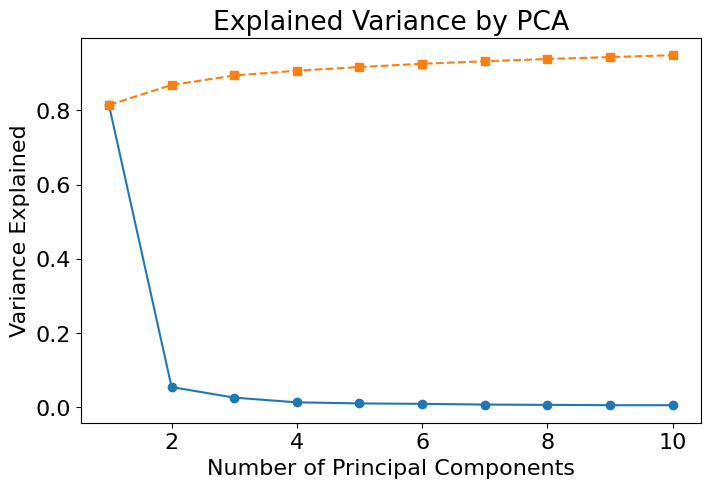

In [43]:

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")


## UMAP assessment

In [23]:
repeats = 1
components = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

### Test for different random seeds

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Text(0, 0.5, 'Negative log likelihood (SEM)')

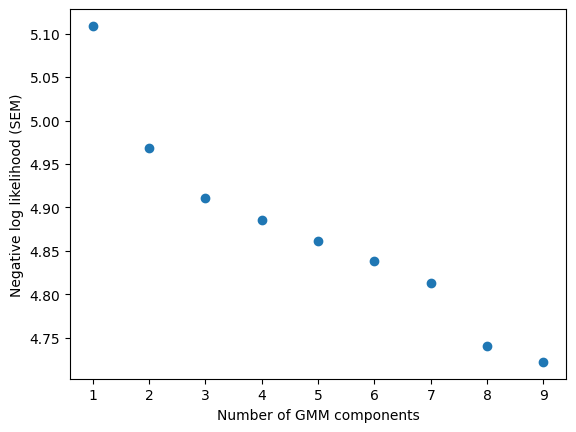

In [24]:
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    
    reducer = umap.UMAP(n_components=2)  # Allow for random seed on each iteration

    # Standardization using StandardScaler
    scaler = StandardScaler()
    standardized_X = scaler.fit_transform(ori_X)

    embeding = reducer.fit_transform(ori_X)
    embeding.shape
    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_neg_log_likelihood(embeding, components)
    
plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Negative log likelihood (SEM)')


## Run UMAP with fixed random seed

### Test for different min_dist 

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


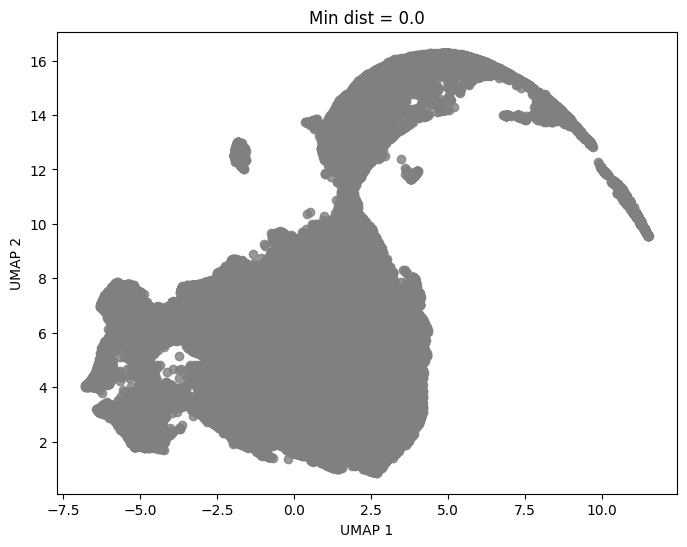

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


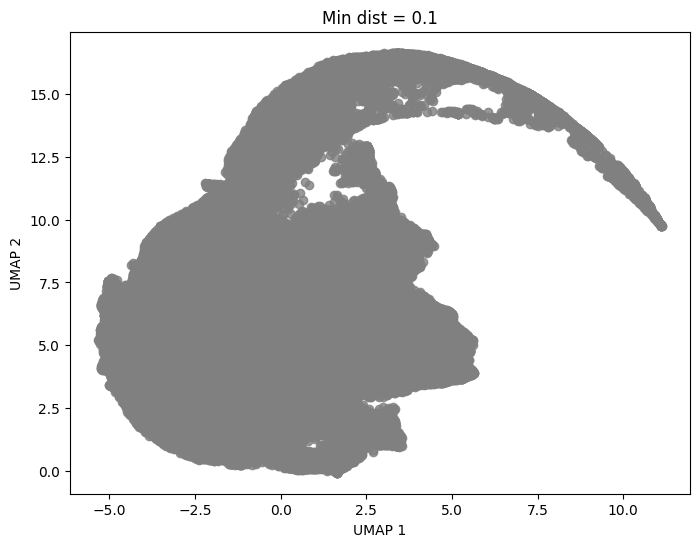

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [11]:
repeats = 3
components = np.array([2, 5, 6, 9])
min_dists = np.array([0.0, 0.1, 0.5, 0.99]) 
LL_min_dist = np.zeros((len(min_dists), len(components))) * np.nan

for d, min_dist in enumerate(min_dists):    
    LLs = np.zeros((repeats, len(components))) * np.nan
    
    for r in range(repeats):  
        
        reducer = umap.UMAP(n_components=2, min_dist=min_dist)  # Allow for random seed on each iteration

        # Standardization using StandardScaler
        scaler = StandardScaler()
        standardized_X = scaler.fit_transform(ori_X)

        mouse_embedding = reducer.fit_transform(ori_X)
        mouse_embedding.shape
        
        # Compute log likelihood of a GMM model with different components
        LLs[r, :] = GMM_neg_log_likelihood(mouse_embedding, components)
    
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        mouse_embedding[:, 0],
        mouse_embedding[:, 1],
        alpha=0.8,
        c='grey'  # Choose a colormap
    )  
    plt.title(str('Min dist = '+str(min_dist)))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    
    # Compute log likelihood of a GMM model with different components
    LL_min_dist[d, :] = np.mean(LLs, axis=0)
    
plt.imshow(LL_min_dist)
plt.yticks([0, 1, 2, 3, 4, 5], min_dists)
plt.xticks(np.arange(0, len(components), 1), components)
# plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(len(min_dists)), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Minimum distance')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")

### Test for different n_neighbours

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


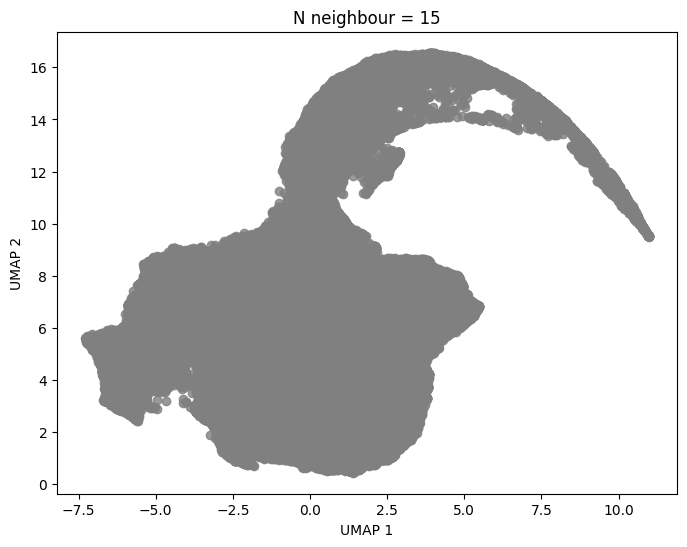

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


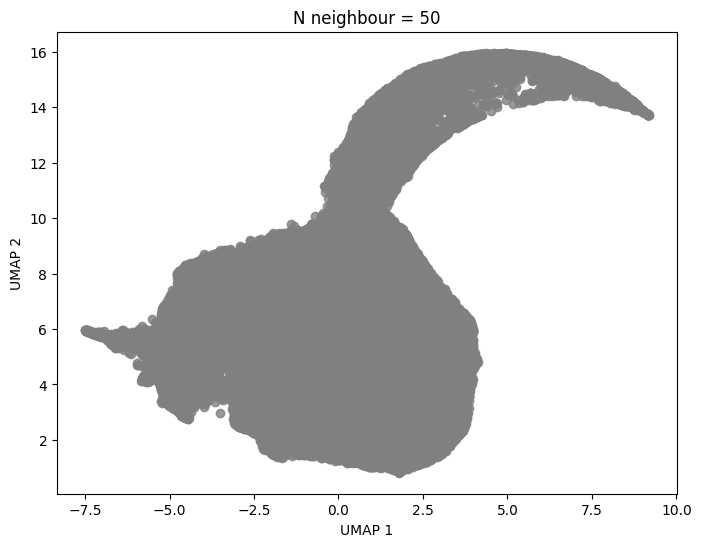

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


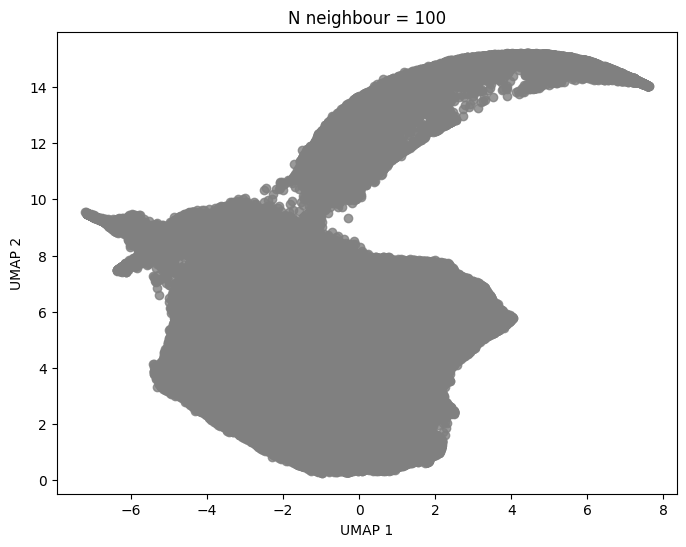

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


: 

In [12]:
repeats = 1
n_neighbours = np.array([15, 50, 100, 1000]) 
LL_neighbours = np.zeros((len(n_neighbours), len(components))) * np.nan

for n, n_neighbour in enumerate(n_neighbours):    
    LLs = np.zeros((repeats, len(components))) * np.nan
    
    for r in range(repeats):  
        
        reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbour)  # Allow for random seed on each iteration

        # Standardization using StandardScaler
        scaler = StandardScaler()
        standardized_X = scaler.fit_transform(ori_X)

        mouse_embedding = reducer.fit_transform(ori_X)
        mouse_embedding.shape
        
        # Compute log likelihood of a GMM model with different components
        LLs[r, :] = GMM_neg_log_likelihood(mouse_embedding, components)
    
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        mouse_embedding[:, 0],
        mouse_embedding[:, 1],
        alpha=0.8,
        c='grey'  # Choose a colormap
    )  
    plt.title(str('N neighbour = '+str(n_neighbour)))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    
    # Compute log likelihood of a GMM model with different components
    LL_neighbours[n, :] = np.mean(LLs, axis=0)
    
plt.imshow(LL_neighbours)
plt.yticks([0, 1, 2, 3], n_neighbours)
plt.xticks(np.arange(0, len(components), 1), components)
# plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(len(min_dists)), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('N neighbors')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")

In [45]:
reducer = umap.UMAP(random_state= 42, n_components=2)
# reducer = umap.UMAP(n_components=2)

# # Standardization using StandardScaler
# scaler = StandardScaler()
# standardized_X = scaler.fit_transform(X)

# embedding = reducer.fit_transform(standardized_X)
# embedding.shape

embedding = reducer.fit_transform(X_pca)
embedding.shape


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(136683, 2)

/tmp/ipykernel_23866/3008203576.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


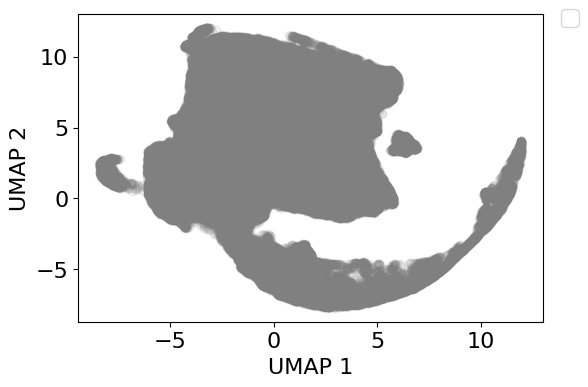

In [46]:
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 16})

scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.1,
    c='grey'  # Choose a colormap
)   
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Save the figure as an SVG file
plt.savefig(file_path+'UMAP_grey', format="svg")

Text(0, 0.5, 'UMAP 2')

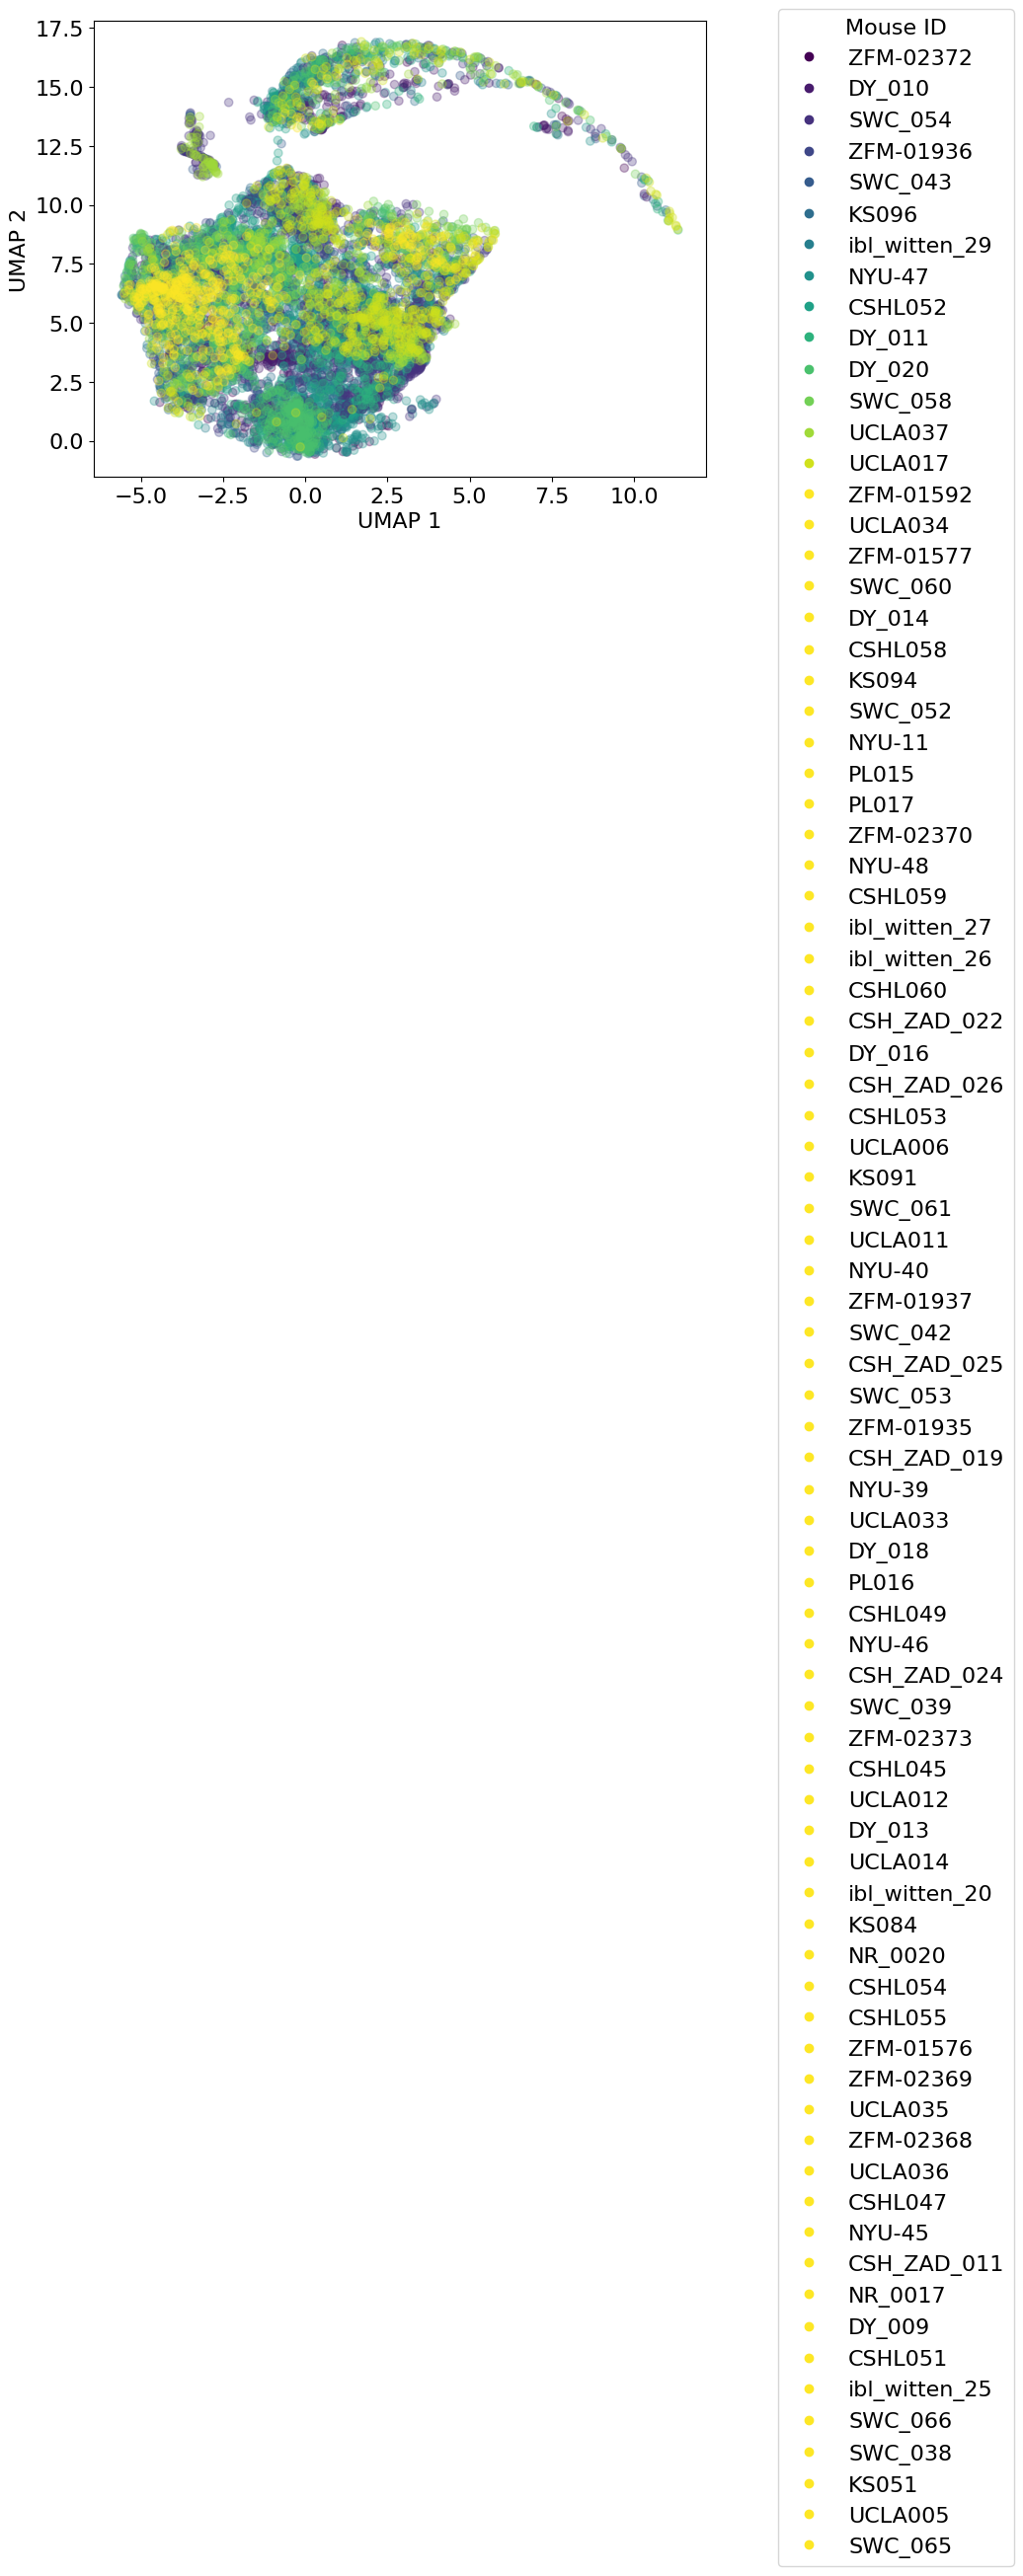

In [21]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    embedding[:, 0][0:10000],
    embedding[:, 1][0:10000],
    alpha=0.3,
    c=mouse_name_numbers[0:10000],
    cmap='viridis'  # Choose a colormap
)   #     c=mouse_name_numbers,

# Create the custom legend
handles = []
for code, label in zip(unique_mouse_labels[:], all_mice['mouse_name'].unique()[:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

plt.legend(handles=handles, title="Mouse ID", bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

Text(0, 0.5, 'UMAP 2')

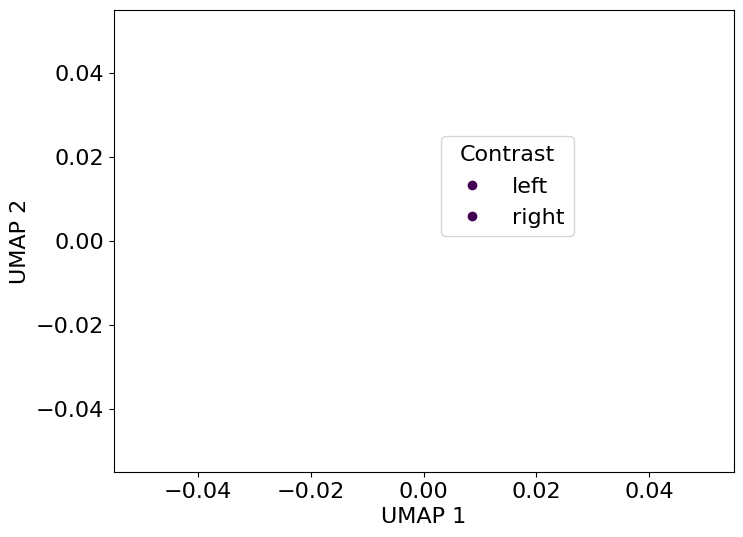

In [28]:
plt.figure(figsize=(8, 6))

filter = all_mice['trial_type'].isin(['incorrect stay', 'incorrect shift'])
filter = all_mice['trial_type'].isin(['correct stay', 'correct shift', 'incorrect stay', 'incorrect shift'])
filter = all_mice['trial_type'].isin(use_order)
plt.rcParams.update({'font.size': 16})

# Plotting the scatter plot
scatter = plt.scatter(
    embedding[:, 0][filter],
    embedding[:, 1][filter],
    c=all_mice.loc[filter, 'numeric_trial_code'],
    alpha=0.05,
    cmap='viridis'  # Choose a colormap
)  

# Create the custom legend
handles = []
for code, label in zip(unique_numeric_labels[0:], use_order[0:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

# x.legend(bbox_to_anchor=(1.1, 1.05))
plt.legend(handles=handles, title="Contrast", bbox_to_anchor=(.76, .75))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.xlim([-15, 25])
# plt.gca().set_aspect('equal', 'datalim')

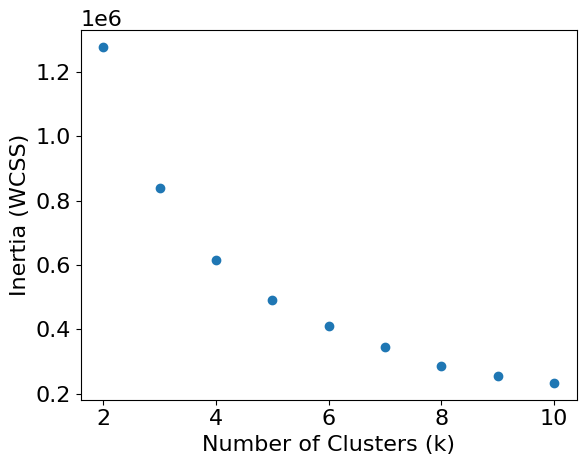

In [29]:
# Assuming `X` is your data
inertia_values = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(embedding)[0]*0.8)
    X_train = np.vstack([embedding[:cutoff, 0], embedding[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)

# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
# plt.title('Elbow Method for Optimal k trials')
# Save the figure as an SVG file
plt.savefig(file_path+'inertia_trials.svg', format="svg")
plt.show()


## K-means clustering of data

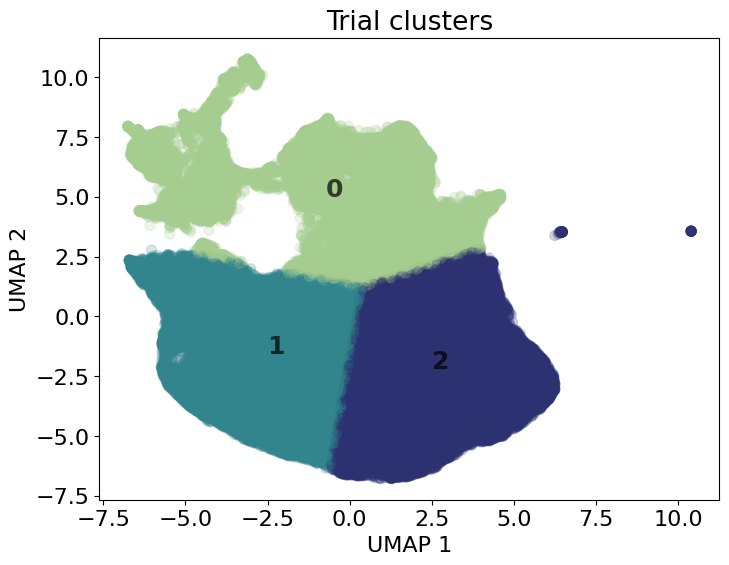

In [34]:
# Step 2: Perform KMeans Clustering
data_2d = embedding
kmeans_trials = KMeans(n_clusters=3, random_state=2024)
kmeans_trials.fit(data_2d)
y_kmeans_trials = kmeans_trials.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=y_kmeans_trials, s=50, alpha=0.2, cmap=sns.color_palette("crest", as_cmap=True)) # , cmap='Set2'

# Plot the centroids
centroids = kmeans_trials.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')


plt.title("Trial clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Save the figure as an SVG file
plt.savefig(file_path+'clusters_trials_1.svg', format="svg")
plt.show()


## Save trial clusters data

In [78]:
save_df = merged_df.copy()

In [92]:
# Analyze state features
save_df['UMAP1'] = embedding[:, 0]
save_df['UMAP2'] = embedding[:, 1]
save_df['cluster'] = y_kmeans_trials
df_cluster = count.reset_index().merge(save_df[['sample', 'cluster', 'session', 'goCueTrigger_times', 'UMAP1', 'UMAP2']], on='sample')
# df_cluster = df_cluster.merge(sum[['sample', 'broader_label', 'sum']], on=['sample', 'broader_label'])
df_cluster = df_cluster.merge(states_trial_type[['sample', 'reaction', 'response', 'elongation', 'perseverence', 
                                                 'choice', 'contrast', 'wsls', 'correct', 'block']].drop_duplicates(), on=['sample'])
df_cluster = df_cluster.merge(ballistic[['sample', 'ballistic']], on=['sample'])

In [95]:
file_to_save = df_cluster.copy()
filename = "cluster_per_trial"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
metadata = save_and_log(file_to_save, filename, file_format, save_path)